In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
# Obtención de listado de stopwords en español
stop_words = list(stopwords.words('spanish'))

import spacy
import pprint
import pyLDAvis
from gensim import corpora
import pyLDAvis.gensim
import seaborn as sns 
from tqdm import tqdm
import networkx as nx
from gensim.models import CoherenceModel
from collections import Counter
from itertools import chain
from nltk.collocations import *
nlp = spacy.load("es_core_news_sm")
from sentiment_analysis_spanish import sentiment_analysis
# eliminar la función ner para acelerar el procesamiento
nlp.disable_pipes('ner')

/home/cygnus/.local/lib/python3.11/site-packages/spacy/language.py:1067: DeprecationWarning: [W096] The method `nlp.disable_pipes` is now deprecated - use `nlp.select_pipes` instead.
  warnings.warn(Warnings.W096, DeprecationWarning)


['ner']

In [12]:
coments_x = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/twitter/coments_x.csv", usecols=["texto"])
coments_tiktok = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/tiktok/coments_tiktok.csv", usecols=["texto"])
coments_insta = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/insta/coments_insta.csv", usecols=["texto"])
coments_fb = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/facebook/coments_fb.csv", usecols=["texto"])

# Concatenar todos los dataframes

df_coments = pd.concat([coments_fb, coments_x, coments_tiktok, coments_insta], axis=0)
df_coments

,texto
0,Bn día!! Regidor@s ✨
1,Gracias asu tolerancia Firmeza y transparencia...
2,Vamos apoyar con todo al Dr. Carlos Lomelí\nSI...
3,Saludos cordiales desde cocula jalisco México ...
4,Buenos días. q la ciudadanía despierte ya MC p...
...,...
20,jalisco tiene esperanza!!! gobernador 👏🏼👏🏼👏🏼👏...
21,hoy en el se llevó a cabo el donde estuviero...
22,"👉gracias a las asociaciones civiles , y a las..."
23,visita campamento mayto


In [13]:
def data_clean(df):
    """
    Parameters
    ----------
    df : DataFrame con columnas
            'texto','comentarisos'repost', 'likes','views'.
    Returns
    -------
    df_posts : DataFrame
        Retorna dos DataFrames limpios:
            El primero con las columnas 'coment','rt','like','views'.
            El segundo con las columnas 'texto', 'tokens'.
    """
    #df_comunicacion = df[["comentarios", "repost", "likes", "views"]] # Comunicación
    #df_comunicacion = df_comunicacion.fillna(0)
    df = df[["texto"]]
    df['texto'] = df['texto'].apply(lambda x: re.sub(r"(, '[\W\.]')",r"", str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
    df = df.fillna('')
    df['tokens'] = df['texto'].apply(nltk.tokenize.word_tokenize)
    return df#, df_comunicacion


df_coments = data_clean(df_coments)
df_coments

,texto,tokens
0,bn día regidors,"[bn, día, regidors]"
1,gracias asu tolerancia firmeza y transparencia...,"[gracias, asu, tolerancia, firmeza, y, transpa..."
2,vamos apoyar con todo al dr carlos lomelí\nsi ...,"[vamos, apoyar, con, todo, al, dr, carlos, lom..."
3,saludos cordiales desde cocula jalisco méxico ...,"[saludos, cordiales, desde, cocula, jalisco, m..."
4,buenos días q la ciudadanía despierte ya mc pu...,"[buenos, días, q, la, ciudadanía, despierte, y..."
...,...,...
20,jalisco tiene esperanza gobernador ayer toco...,"[jalisco, tiene, esperanza, gobernador, ayer, ..."
21,hoy en el se llevó a cabo el donde estuviero...,"[hoy, en, el, se, llevó, a, cabo, el, donde, e..."
22,gracias a las asociaciones civiles y a las b...,"[gracias, a, las, asociaciones, civiles, y, a,..."
23,visita campamento mayto,"[visita, campamento, mayto]"


In [21]:
#df_comunicacion.to_csv("comunicacion.csv")
def preprocess_text(text):
    """
    Función que elimina los sotop_words del texto tokenizado

    Parameters
    ----------
    text : tokens
        Texto tokenizado.

    Returns
    -------
    words : TYPE
        texto limpio de palabras vacias o stopwords

    """
    stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy","dd","drcarloslomeli","usted","doc","hizo",
                    "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da","doccast", "dr", "doctor", "jalisco","morena",
                    "jajajjaj","drcarloslomeli", "nan", "pendejø"))
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words

df_coments['tokens'] = df_coments.tokens.apply(preprocess_text)
df_coments

,texto,tokens,texto_preprocesado,bigramas_spacy,texto_lematizado
0,bn día regidors,"[bn, regidors]","[bn , regidors]","[(bn, día), (día, regidors)]",bn día regidors
1,gracias asu tolerancia firmeza y transparencia...,"[gracias, asu, tolerancia, firmeza, transparen...","[gracias, asu, tolerancia, firmeza, transparen...","[(gracias, asu), (asu, tolerancia), (toleranci...",gracias asu tolerancia firmeza y transparencia...
2,vamos apoyar con todo al dr carlos lomelí\nsi ...,"[vamos, apoyar, carlos, lomelí, puede, vamos, ...","[apoyar, dr, carlos, lomelí, jalisco, tomatlar]","[(vamos, apoyar), (apoyar, con), (con, todo), ...",ir apoyar con todo al dr carlos lomelí \n si p...
3,saludos cordiales desde cocula jalisco méxico ...,"[saludos, cordiales, cocula, méxico, cuna, mun...","[saludo, cordial, cocula, jalisco, méxico, cun...","[(saludos, cordiales), (cordiales, desde), (de...",saludo cordial desde cocula jalisco méxico cun...
4,buenos días q la ciudadanía despierte ya mc pu...,"[buenos, días, ciudadanía, despierte, mc, puro...","[q, ciudadanía, despierte, mc, puro, robo]","[(buenos, días), (días, q), (q, la), (la, ciud...",buen día q el ciudadanía despierte ya mc puro ...
...,...,...,...,...,...
20,jalisco tiene esperanza gobernador ayer toco...,"[esperanza, gobernador, ayer, toco, distrito, ...","[jalisco, esperanza, gobernador, ayer, tocar, ...","[(jalisco, tiene), (tiene, esperanza), (espera...",jalisco tener esperanza gobernador ayer to...
21,hoy en el se llevó a cabo el donde estuviero...,"[llevó, cabo, rector, udg, coordinador, estata...","[llevar, cabo, estar, rector, udg, coordinador...","[(hoy, en), (en, el), (el, ), ( , se), (se, l...",hoy en el él llevar a cabo el donde estar ...
22,gracias a las asociaciones civiles y a las b...,"[gracias, asociaciones, civiles, brigadas, sal...","[gracias, asociación, civil, brigada, salud, i...","[(gracias, a), (a, las), (las, asociaciones), ...",gracias a el asociación civil y a el brigad...
23,visita campamento mayto,"[visita, campamento, mayto]","[visita, campamento, mayto]","[(visita, campamento), (campamento, mayto)]",visita campamento mayto


/home/cygnus/.local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


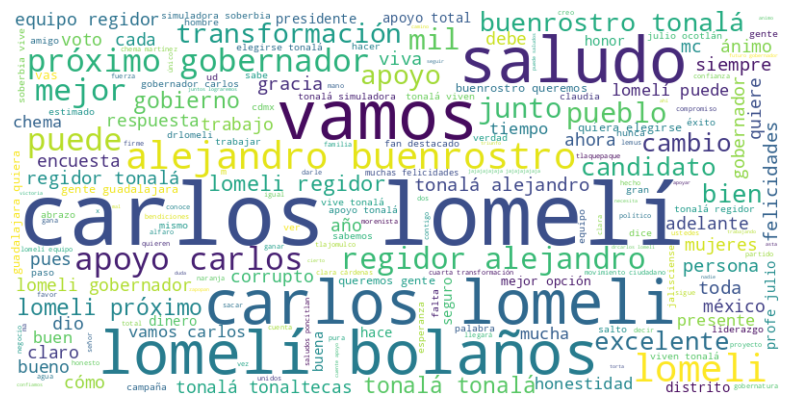

In [37]:
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in df_coments.tokens for word in sublist]
# DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()
# Palabras más comunes 
top_words = word_counts.head(10)

texto = " ".join(all_words)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texto)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("nube_coments.png", dpi=200, bbox_inches="tight")
plt.show()

In [39]:
# Función para preprocesar el texto
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar el preprocesamiento a cada fila del DataFrame
df_coments['texto_preprocesado'] = df_coments.texto.apply(preprocess_text)

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas

df_coments['bigramas_spacy'] = df_coments['texto_lematizado'].apply(generar_bigramas_spacy)

flatten_corpus = [w for l in df_coments.bigramas_spacy for w in l]

treshold = 4

bigrams = [bigram for bigram in flatten_corpus if len(bigram[0])>treshold and len(bigram[1])>treshold]
bigram_measure = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(bigrams)
finder.apply_freq_filter(2)
colocaciones = finder.nbest(bigram_measure.pmi, 20)
colocaciones

[('abogada', 'esquivel'),
 ('arturo', 'núñez'),
 ('asamblea', 'informativo'),
 ('banco', 'scotiabankclabe'),
 ('carmelitir', 'casilla'),
 ('cesar', 'duarte'),
 ('comentarista', 'noticioso'),
 ('compás', 'frecuentado'),
 ('constitución', 'ahhhhh'),
 ('desafortunado', 'silencio'),
 ('gaviota', 'norte'),
 ('jajajjaj', 'pelagato'),
 ('jarocha', 'pendejø'),
 ('paradala', 'bandera'),
 ('pender', 'equivocado'),
 ('preparación', 'eficiencia'),
 ('prestigio', 'cucharero'),
 ('pretexto', 'perfecto'),
 ('robado', 'descaradamente'),
 ('votado', '\n\n\n\n\n ')]

100%|██████████████████████████████████████| 3070/3070 [00:18<00:00, 170.55it/s]


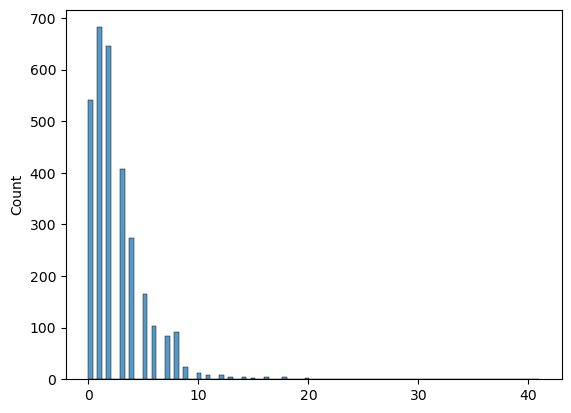

In [27]:
# Función para lematizar el texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

# Aplicar la función de lematización a cada fila del DataFrame
df_coments['texto_lematizado'] = df_coments.texto.apply(lematizar_texto)


# dataset
dataset = df_coments['texto_lematizado']
docs = []
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and 
          not token.is_stop)]
    docs.append(pt)
    
counts_word_occurence = Counter(chain(*[x for x in docs]))

# Palabras con una sola ocurrencia
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>0] for text in docs]
docs_length=len(docs)
# calculate in how many documents a word appeared
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))

# calculate in what % of all articles a word appears
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>5}
lengths =  [len(x) for x in docs]
# Build the histogram, distribution of lemmas in the texts
sns.histplot(lengths)
# Defining dictionary and corpus with Gensim
dictionary = corpora.Dictionary(docs)
dictionary.add_documents(colocaciones)  # Agregar n-gramas al diccionario

corpus = [dictionary.doc2bow(text) for text in docs]

In [28]:
def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):

        # defining the model
        lda_model = LdaModel(corpus, id2word=dictionary, num_topics=25, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()

        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()

        values = [topics, u_mass_coherence, c_v_coherence]

        scores.append(values)

    return scores

In [29]:
from gensim.models import LdaModel
# calculare scores
scores = calculate_coherence(dictionary, corpus, docs, 5, 15)
# scores to df
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])

# tidying the df
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])

df

,number_of_topics,variable,value
0,5,u_mass_coherence,-15.191712
1,6,u_mass_coherence,-15.718930
2,7,u_mass_coherence,-14.994491
3,8,u_mass_coherence,-15.487750
4,9,u_mass_coherence,-15.761391
5,10,u_mass_coherence,-15.368385
6,11,u_mass_coherence,-15.324056
7,12,u_mass_coherence,-15.387418
8,13,u_mass_coherence,-15.432550
9,14,u_mass_coherence,-15.300239


Text(0.5, 1.0, 'u_mass coherence')

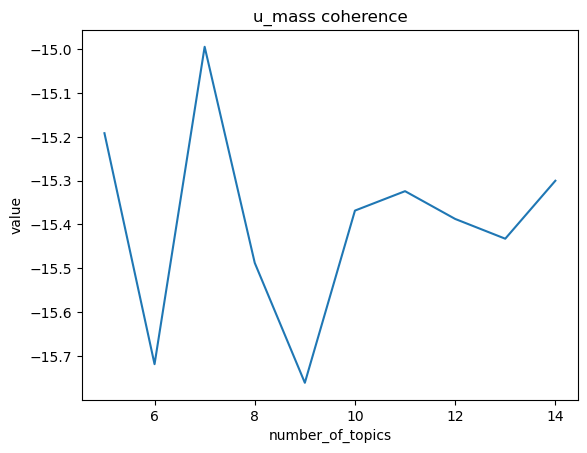

In [30]:
# Plotting u_mass_coherence
sns.lineplot(data=df.loc[df['variable'] == 'u_mass_coherence'], x="number_of_topics", y="value").set_title('u_mass coherence')

Text(0.5, 1.0, 'c_v coherence')

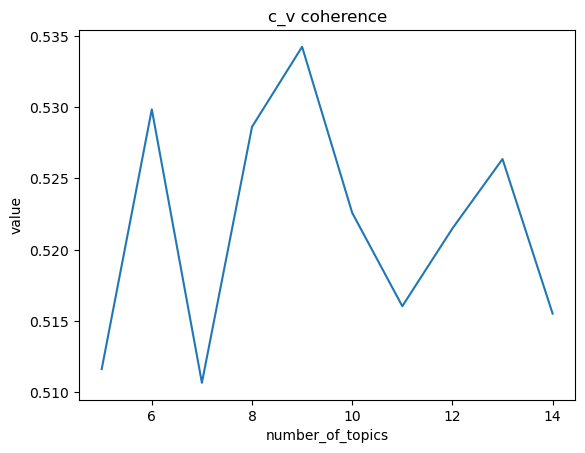

In [31]:
# Plotting c_v_coherence
sns.lineplot(data=df.loc[df['variable'] == 'c_v_coherence'], x="number_of_topics", y="value").set_title('c_v coherence')

In [32]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=10, alpha='auto', eval_every=5, passes=8)

# print topics
topics = lda_model.print_topics(-1)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.055*"cambio" + 0.026*"movimiento" + 0.026*"chayote" + 0.018*"fuerza" + 0.018*"defensa" + 0.017*"salto" + 0.016*"comités" + 0.016*"vida" + 0.015*"presidente" + 0.015*"traidor"')
(1, '0.139*"jalisco" + 0.071*"morena" + 0.050*"dr" + 0.043*"candidato" + 0.036*"gobernador" + 0.022*"pueblo" + 0.021*"transformación" + 0.017*"año" + 0.016*"mujer" + 0.014*"jajajajajaja"')
(2, '0.193*"doctor" + 0.052*"jalisco" + 0.036*"gobernador" + 0.031*"honestidad" + 0.025*"felicidad" + 0.023*"apoyo" + 0.023*"gobierno" + 0.022*"julio" + 0.016*"cambio" + 0.014*"honor"')
(3, '0.100*"saludo" + 0.024*"amigo" + 0.020*"dr" + 0.019*"edificio" + 0.019*"municipio" + 0.018*"unidad" + 0.017*"abrazo" + 0.015*"bendición" + 0.015*"apoyo" + 0.014*"perfil"')
(4, '0.218*"dr" + 0.108*"apoyo" + 0.107*"tonalá" + 0.064*"buenrostro" + 0.041*"regidor" + 0.036*"equipo" + 0.032*"gente" + 0.029*"saludo" + 0.013*"persona" + 0.012*"líder"')
(5, '0.027*"tiempo" + 0.024*"transformación" + 0.023*"jalisco" + 0.020*"deber" + 0.019*"ho

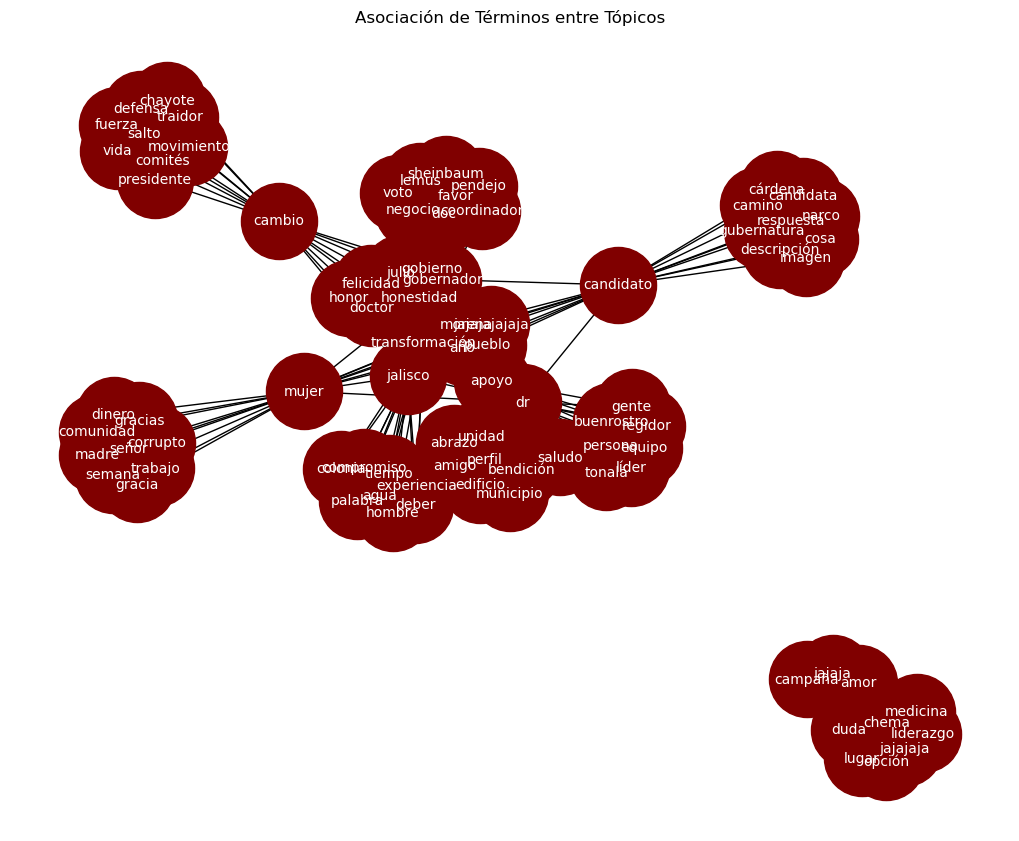

In [33]:
# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='white')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

def obtener_palabras(texto):
    palabras = re.findall(r'"([^"]*)"', texto)
    return palabras

# Aplicar la función a cada elemento del arreglo
solo_palabras = [(indice, obtener_palabras(texto)) for indice, texto in topics]

topicos = pd.DataFrame(solo_palabras,  columns=['No. Topico', 'Palabras Clave'])
topicos.to_csv("topicos_coments.csv")